# Total column water vapour retrieval using GP emulators

### Feng Yin and J Gómez-Dans


Basically, the current method uses a LUT. The LUT provides two parameters $b_0$ and $b_1$ as a function of $[\rho_{8A, TOA}, sza, vza, raa, elev]$. TCWV is then calculated as

$$
wv = \left( b_0  - \log_{10}\left[\frac{K_{8A}\cdot \rho_{8A, TOA}}{K_{9}\cdot\rho_{9, TOA}} \right] + b1 \right)^2
$$

It would be very nice to implement this mapping as an emulator that takes the relevant paramters and predicts total column water vapour directly. Apart from being very fast, it would also allow one to calculate uncertainty directly. On the one hand, we can easily calculate the uncertainty in using a limited sampling set (e.g. the LUT), but we can also have access to the gradient $wv$ as a function of the TOA reflectances, so that we can also propagate the uncertainty through the entire retreival.

In this note, we'll use BC's internal LUT, and implement the previous equation using the LUT, which will then use to train a gp emulator to mimick the equation above.



In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import cPickle

import gp_emulator
%matplotlib inline

# STart by getting BC's LUT


if not os.path.exists("water_vapour_lut_CIBR_9_8A.txt"):
    r = requests.get("https://github.com/senbox-org/s2tbx/raw/master/" + 
                     "s2tbx-s2msi-aerosol-retrieval/src/main/resources/" + 
                     "org/esa/s2tbx/s2msi/wv/water_vapour_lut_CIBR_9_8A.txt")
    with open("water_vapour_lut_CIBR_9_8A.txt", 'w') as fp:
        fp.write (r.text)

LUT = np.loadtxt("water_vapour_lut_CIBR_9_8A.txt", skiprows=5, delimiter=";")
print LUT.shape
    

(6125, 7)


In [2]:
def calculate_tcwv ( rho_9, rho_8a, vza, sza, raa, elev):
    """Function that calculates TCWV as a function of
    TOA reflectances, view/illumination geometry and elevation
    (in km). Note that we make an assumption on the extraterrestrial
    solar irradiance for S2MSI bands 8a and 9.
    
    **NOTE** Function also assumes that LUT is present in 
    the namespace, and that it looks like the LUT above"""
    band_ratio = 955.19/813.04
    log_cibr = np.log10(band_ratio*rho_8a/rho_9)
    x = np.array([rho_8a, vza, sza, raa, elev])
    idx = np.linalg.norm(LUT[:, :-2] - x, axis=1).argmin()
    b0, b1 = LUT[idx, -2:]
    wv = b0*log_cibr + b1
    wv = wv**2
    return wv


We now have a function that produces the desired mapping. We will now create a training set that we'll use to train an emulator as a surrogate of `calculate_tcwv`. For this we're using 1000 training samples, which seems to be enough, although we've not really looked at the optimal number of samples.

In [3]:
parameters ="rho_9, rho_8a, vza, sza, raa, elev".split(",")
minvals = np.r_[ 0.05, LUT[:, :-2].min(axis=0)]
maxvals = np.r_[ 0.8, LUT[:, :-2].max(axis=0)]
training_set = gp_emulator.create_training_set(parameters, minvals, maxvals, n_train=1000)

tcwv = []
for x in training_set[0]:
    tcwv.append( calculate_tcwv ( *x ))
tcwv = np.array(tcwv)
    

We create a validation dataset here. The validation dataset only tests how good the emulator mimicks the full function for unseen parameter combinations, it's not a validation of the water retrieval scheme!

In [4]:
val_set = gp_emulator.create_validation_set(training_set[1], n_validate=1000)
tcwv_val = []
for x in val_set:
    tcwv_val.append( calculate_tcwv ( *x ))
tcwv_val = np.array(tcwv_val)

We need to train the emulator. Note that with 1000 parameters, this takes a while, so you may want to skip this and just load a "canned" version of the emulator which we provide as a pickle file:

In [5]:
train = False
if train:
    gp = gp_emulator.GaussianProcess(training_set[0],  tcwv)
    gp.learn_hyperparameters(verbose=True, n_tries=5)
    cPickle.dump(gp, open("wv_msi_retrieval_NEW.pkl", 'w'))
else:
    gp = cPickle.load(open("wv_msi_retrieval.pkl", 'rb'))

We can now check the validation. We'll see how that goes and plot the validation errors (squared) as a function of input parameters...

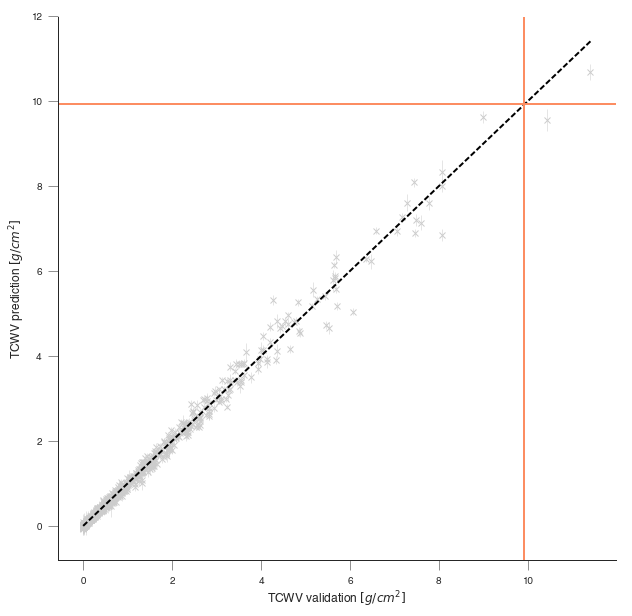

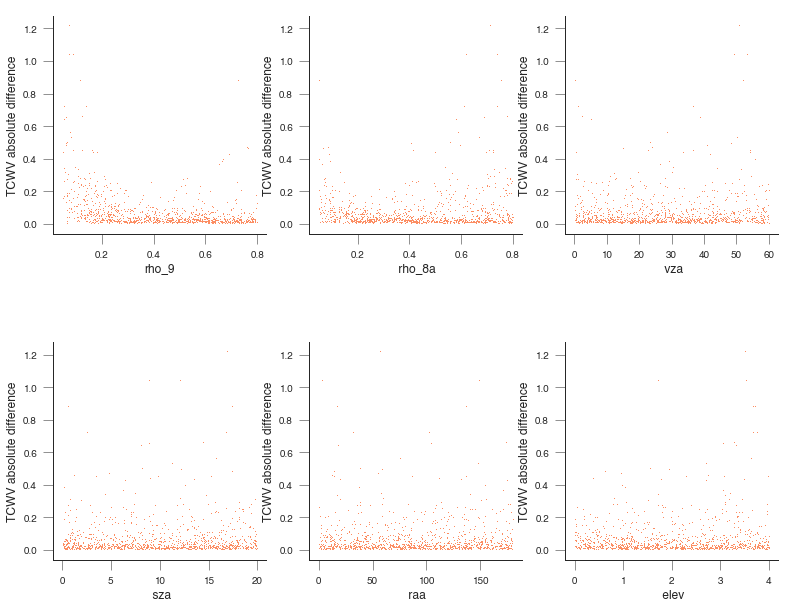

In [6]:
val_set_emu, val_set_unc, _ = gp.predict(val_set, do_unc=True, do_deriv=None)

plt.figure(figsize=(10,10))
plt.plot(tcwv_val, val_set_emu, 'x', color="0.8")
plt.plot([0, max(tcwv_val.max(), val_set_emu.max())], 
         [0, max(tcwv_val.max(), val_set_emu.max())], 'k--')
plt.vlines(tcwv_val, val_set_emu-1.96*np.sqrt(val_set_unc),
          val_set_emu + 1.96*np.sqrt(val_set_unc), color="0.8", lw=0.5)
plt.axhline(tcwv.max())
plt.axvline(tcwv.max())
plt.xlabel("TCWV validation $[g/cm^2]$")
plt.ylabel("TCWV prediction $[g/cm^2]$")
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(13,10))
axs = axs.flatten()
for i in xrange(6):
    axs[i].set_ylabel("TCWV absolute difference")
    axs[i].plot(val_set[:, i], np.abs(tcwv_val - val_set_emu), ',')
    axs[i].set_xlabel(parameters[i])

The previous results show that the emulator is performing well over the entire parameter range, with differences between emulator and full LUT-derived function usually resulting in errors that are most of the time less than 0.5 $g cm^{-2}$. The larger discrepancies happen when band 9 reflectance is very low, which is evidence of very high water vapour content (values larger than 6 $g cm^{-2}$).

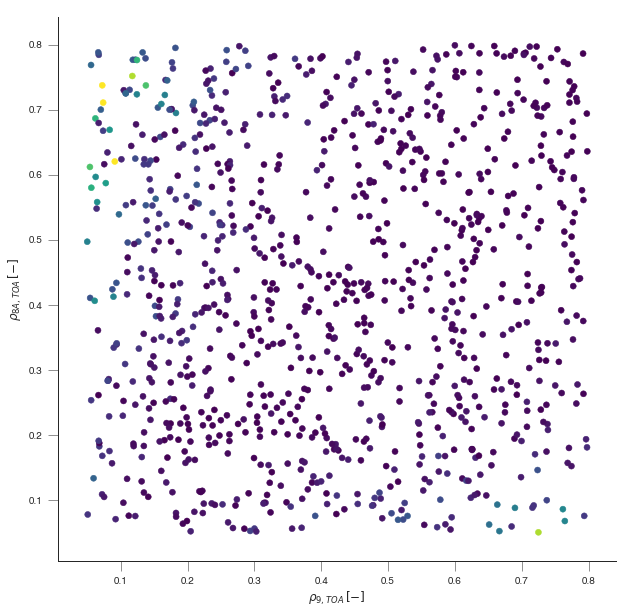

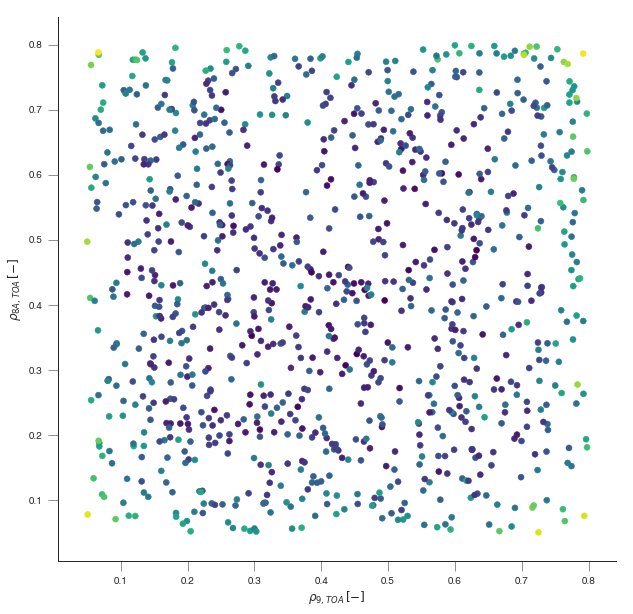

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(val_set[:, 0], val_set[:, 1], 
            c=np.abs(tcwv_val - val_set_emu), vmin=0, vmax=1 )

plt.xlabel(r"$\rho_{9,TOA}\,[-]$")
plt.ylabel(r"$\rho_{8A,TOA}\,[-]$")


plt.figure(figsize=(10,10))
plt.scatter(val_set[:, 0], val_set[:, 1], 
            c=np.log(np.sqrt(val_set_unc)))

plt.xlabel(r"$\rho_{9,TOA}\,[-]$")
plt.ylabel(r"$\rho_{8A,TOA}\,[-]$")